In [17]:
import wordgraph as wg
import os

from ggplot import *
import pandas as pd
from scipy import stats
import numpy as np

In [18]:
G = wg.WordGraph()

In [19]:
def range_degree_merge_wb(graph_dir, wordbank_csv):
    wb_data = pd.read_csv(wordbank_csv)
    wb_data['definition'] = wb_data['definition'].str.strip().str.replace("+", "-").str.replace(" ", "-").str.lower()
    deg_dists = []
    
    for root, dirs, files in os.walk(graph_dir):
        for file in files:
            if not file.startswith("."):
                file = os.path.join(root, file)
                G.load_pickle(file)
                deg_dist = G.degree_distribution()
                deg_dist = pd.merge(deg_dist, wb_data, left_on='word', right_on='definition')
                deg_dists.append((G.epsilon, deg_dist))              
    return deg_dists

In [20]:
def spearman_dist_range(wordset, degree_dists, month):
    df = pd.DataFrame(columns=['wordset', 'epsilon', 'rho', 'p', 'cdi_month'])
    for pair in degree_dists:
        rho, p = stats.spearmanr(pair[1]['degree'], pair[1][month])
        entry = pd.DataFrame([[wordset, pair[0], rho, p, month]], columns=['wordset', 'epsilon', 'rho', 'p', 'cdi_month'])
        df = df.append(entry, ignore_index=True)
    return df

In [21]:
def range_discrete_learn_rate_btm(output, wordset=None, deg_dist=None, month1=None, month2=None):
    result = pd.DataFrame(columns=['wordset', 'epsilon', 'U', 'p', 'cdi_month'])
    for eps, df in deg_dist:
        df['learn_t1'] = 0
        df['learn_t2'] = 0

        t1_median = df[month1].median(axis=0)
        df.loc[df[month1] >= t1_median, 'learn_t1'] = 1

        t2_median = df[df['learn_t1'] == 0][month2].median(axis=0)
        df.loc[df[month2] >= t2_median, 'learn_t2'] = 1
        
        btm = df[df['learn_t1'] == 0]
        btm.to_csv(os.path.join(output, wordset, "{}.csv".format(eps)), index=False)
    return result

In [22]:
def range_discrete_learn_rate_top(output, wordset=None, deg_dist=None, month1=None, month2=None):
    result = pd.DataFrame(columns=['wordset', 'epsilon', 'U', 'p', 'cdi_month'])
    for eps, df in deg_dist:
        df['learn_t1'] = 0
        df['learn_t2'] = 0

        t1_median = df[month1].median(axis=0)
        df.loc[df[month1] >= t1_median, 'learn_t1'] = 1
        df.to_csv(os.path.join(output, wordset, "{}.csv".format(eps)), index=False)

#         t2_median = df[df['learn_t1'] == 0][month2].median(axis=0)
#         df.loc[df[month2] >= t2_median, 'learn_t2'] = 1
        
#         top = df[df['learn_t1'] == 1]
#         btm.to_csv(os.path.join(output, wordset, "{}.csv".format(eps)), index=False)
    return result

## Merge WordBank comprehension scores with SEEDLings degree distributions

In [23]:
degree_dists_6mo = range_degree_merge_wb(graph_dir='/Volumes/Lexar/semspace_output/seedlings_6mo_no_CHI',
                                         wordbank_csv='data/wordbank_english.csv')

degree_dists_1617mo = range_degree_merge_wb(graph_dir='/Volumes/Lexar/semspace_output/seedlings_1617mo_no_CHI',
                                            wordbank_csv='data/wordbank_english.csv')

degree_dists_all = range_degree_merge_wb(graph_dir='/Volumes/Lexar/semspace_output/seedlings_all_no_CHI',
                                         wordbank_csv='data/wordbank_english.csv')

wb_degree_dist = range_degree_merge_wb(graph_dir='/Volumes/Lexar/semspace_output/wordbank',
                                       wordbank_csv='data/wordbank_english.csv')

In [17]:
# eps, df = degree_dists_6mo[0]

# month1='16'
# month2='30'

# df['learn_t1'] = 0
# df['learn_t2'] = 0

# t1_median = df[month1].median(axis=0)
# df.loc[df[month1] >= t1_median, 'learn_t1'] = 1

# t2_median = df[df['learn_t1'] == 0][month2].median(axis=0)
# df.loc[df[month2] >= t2_median, 'learn_t2'] = 1

# df[df['learn_t1'] == 0]

In [24]:
%%capture
seed_6mo_16 = spearman_dist_range('seedlings_6mo', degree_dists_6mo, '16')
seed_1617mo_16 = spearman_dist_range('seedlings_1617mo', degree_dists_1617mo, '16')
seed_all_16 = spearman_dist_range('seedlings_all', degree_dists_all, '16')

seed_6mo_23 = spearman_dist_range('seedlings_6mo', degree_dists_6mo, '23')
seed_1617mo_23 = spearman_dist_range('seedlings_1617mo', degree_dists_1617mo, '23')
seed_all_23 = spearman_dist_range('seedlings_all', degree_dists_all, '23')

seed_6mo_30 = spearman_dist_range('seedlings_6mo', degree_dists_6mo, '30')
seed_1617mo_30 = spearman_dist_range('seedlings_1617mo', degree_dists_1617mo, '30')
seed_all_30 = spearman_dist_range('seedlings_all', degree_dists_all, '30')

# seed_6mo_23_30 = spearman_dist_range('seedlings_6mo', degree_dists_6mo, '23_to_30')
# seed_1617mo_23_30 = spearman_dist_range('seedlings_1617mo', degree_dists_1617mo, '23_to_30')
# seed_all_23_30 = spearman_dist_range('seedlings_all', degree_dists_all, '23_to_30')

wordbank_16 = spearman_dist_range('wordbank', wb_degree_dist, "16")
wordbank_23 = spearman_dist_range('wordbank', wb_degree_dist, "23")
wordbank_30 = spearman_dist_range('wordbank', wb_degree_dist, "30")
# wordbank_23_30 = spearman_dist_range('wordbank', wb_degree_dist, "23_to_30")

data = pd.concat([seed_6mo_16, seed_1617mo_16, seed_all_16,
                 seed_6mo_23, seed_1617mo_23, seed_all_23,
                 seed_6mo_30, seed_1617mo_30, seed_all_30,
                # seed_6mo_23_30, seed_1617mo_23_30, seed_all_23_30,
                 wordbank_16, wordbank_23, wordbank_30])

data.to_csv('output/wordlearning.csv', index=False)

In [7]:
seed_6mo_rate = range_discrete_learn_rate_btm('/Volumes/Lexar/semspace_output/learning', wordset='seedlings_6mo',
                              deg_dist=degree_dists_6mo, month1='16', month2='30')

seed_1617_rate = range_discrete_learn_rate_btm('/Volumes/Lexar/semspace_output/learning', wordset='seedlings_1617mo',
                              deg_dist=degree_dists_1617mo, month1='16', month2='30')

seed_all_rate = range_discrete_learn_rate_btm('/Volumes/Lexar/semspace_output/learning', wordset='seedlings_all',
                              deg_dist=degree_dists_all, month1='16', month2='30')

data = pd.concat([seed_6mo_rate, seed_1617_rate, seed_all_rate])
data.to_csv('output/wordlearning_rate.csv', index=False)

In [30]:
seed_6mo_rate = range_discrete_learn_rate_top('/Volumes/Lexar/semspace_output/learning/top30', wordset='seedlings_6mo',
                              deg_dist=degree_dists_6mo, month1='30', month2='30')

seed_1617_rate = range_discrete_learn_rate_top('/Volumes/Lexar/semspace_output/learning/top30', wordset='seedlings_1617mo',
                              deg_dist=degree_dists_1617mo, month1='30', month2='30')

seed_all_rate = range_discrete_learn_rate_top('/Volumes/Lexar/semspace_output/learning/top30', wordset='seedlings_all',
                              deg_dist=degree_dists_all, month1='23', month2='30')

wb_rate = range_discrete_learn_rate_top('/Volumes/Lexar/semspace_output/learning/top30', wordset='wordbank',
                              deg_dist=wb_degree_dist, month1='30', month2='30')

data = pd.concat([seed_6mo_rate, seed_1617_rate, seed_all_rate, wb_rate])
data.to_csv('output/wordlearning_rate.csv', index=False)

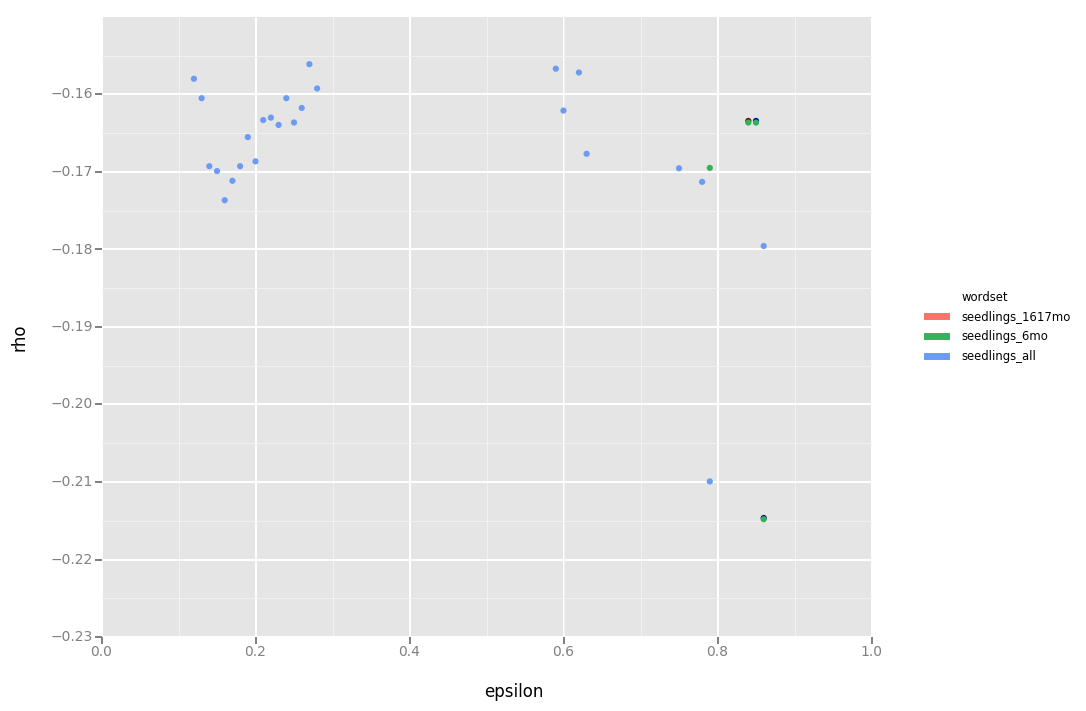

<ggplot: (330643313)>

In [176]:
ggplot(data[data['p']<0.05], aes(x='epsilon', y='rho', color='wordset'))+\
    geom_point()


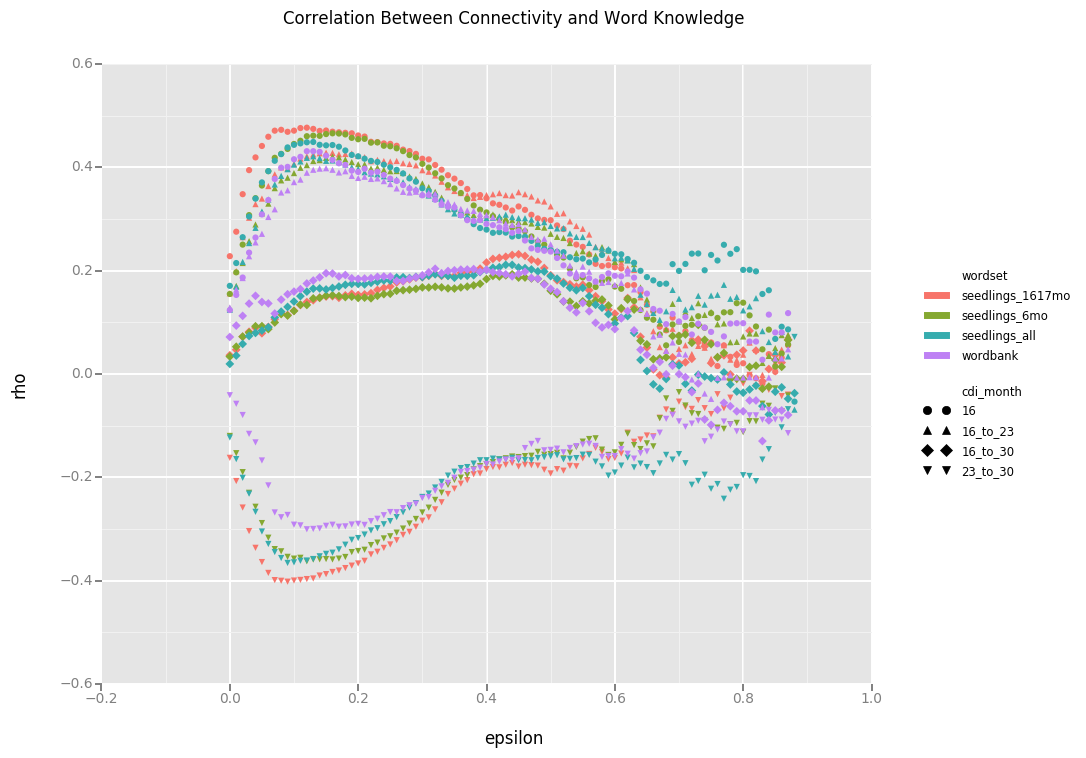

<ggplot: (-9223372036536308245)>

In [16]:
p = ggplot(data, aes(x='epsilon', y='rho', color='wordset', shape='cdi_month'))+\
    geom_point()+\
    ggtitle('Correlation Between Connectivity and Word Knowledge')
    
p

## Plot correlation as a function of epsilon

### SEEDLings 6 Month

In [53]:
%%capture
kendall_df = kendall_dist_range(degree_dists_6mo)
spearman_df = spearman_dist_range(degree_dists_6mo, '16')

spearman_df.to_csv('output/edges_vs_cdi_seedlings6mo.csv', index=False)

max rho: 

epsilon    1.600000e-01
rho        4.658167e-01
p          1.737433e-16
Name: 16, dtype: float64


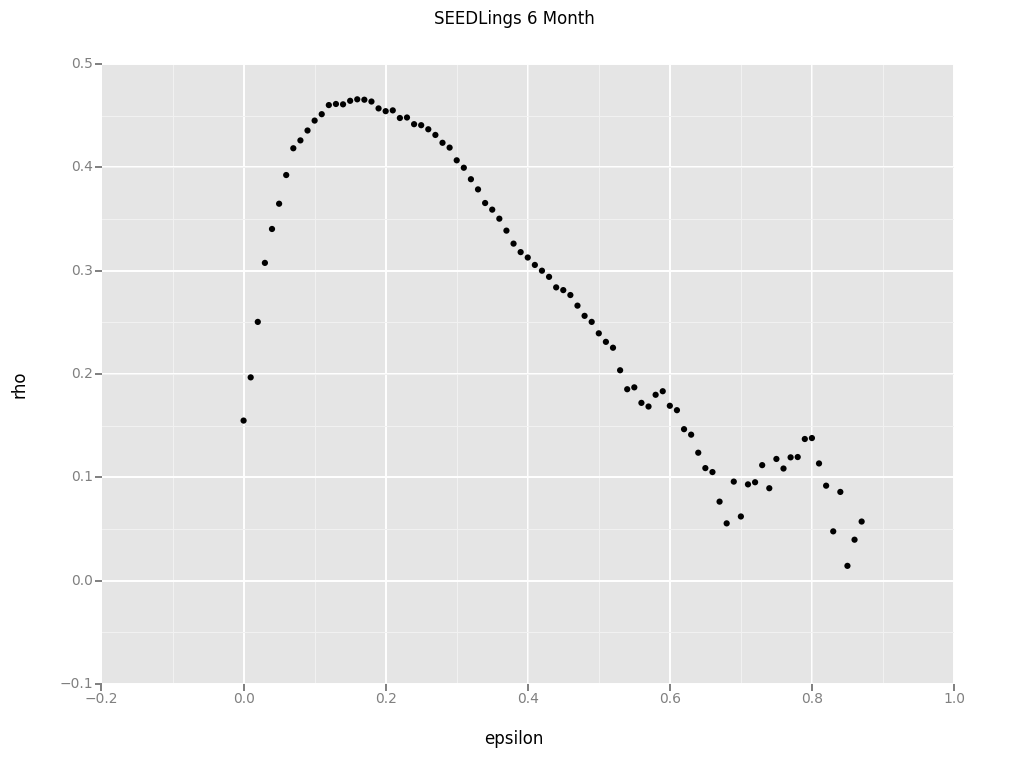

<ggplot: (-9223372036529299596)>

In [33]:
print("max rho: \n\n{}".format(spearman_df.loc[spearman_df.rho.idxmax()]))

p = ggplot(spearman_df, aes(x='epsilon', y='rho'))+\
    geom_point()+\
    ggtitle('SEEDLings 6 Month')
    
p.save('graphs/edges_vs_cdi_seedlings6mo.png')
p

### SEEDLings 16+17 Month

In [54]:
%%capture
kendall_df = kendall_dist_range(degree_dists_1617mo)
spearman_df = spearman_dist_range(degree_dists_1617mo, '16')

spearman_df.to_csv('output/edges_vs_cdi_seedlings1617mo.csv', index=False)

max rho: 

epsilon    1.200000e-01
rho        4.767337e-01
p          3.078581e-17
Name: 12, dtype: float64


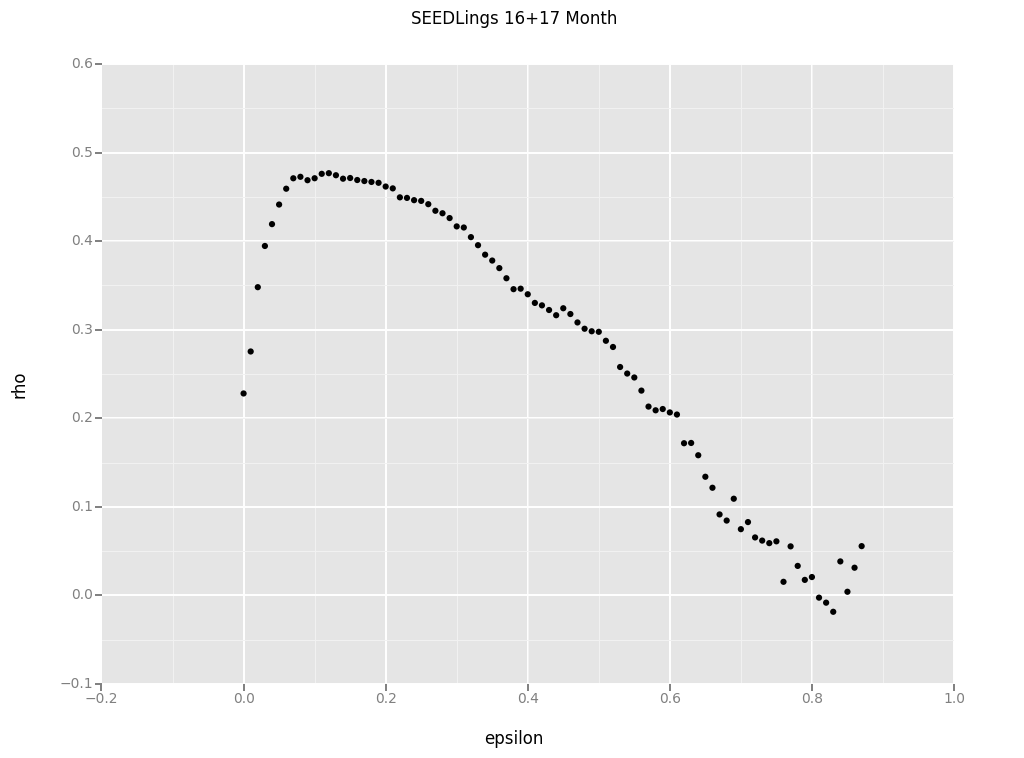

<ggplot: (346224069)>

In [35]:
print("max rho: \n\n{}".format(spearman_df.loc[spearman_df.rho.idxmax()]))

p = ggplot(spearman_df, aes(x='epsilon', y='rho'))+\
    geom_point()+\
    ggtitle('SEEDLings 16+17 Month')
    
p.save('graphs/edges_vs_cdi_seedlings1617mo.png')
p

### SEEDLings All Months

In [55]:
%%capture
kendall_df = kendall_dist_range(degree_dists_all)
spearman_df = spearman_dist_range(degree_dists_all, '16')

spearman_df.to_csv('output/edges_vs_cdi_seedlings_all.csv', index=False)

max rho: 

epsilon    1.300000e-01
rho        4.490774e-01
p          5.461350e-17
Name: 13, dtype: float64


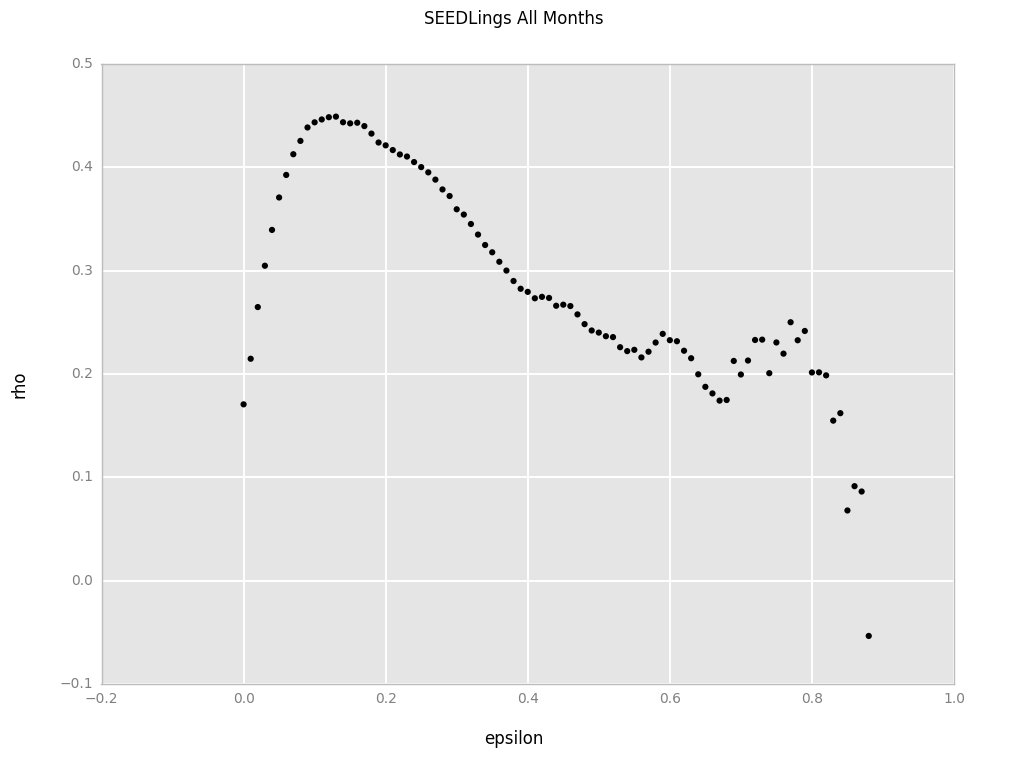

<ggplot: (299947454)>

In [50]:
print("max rho: \n\n{}".format(spearman_df.loc[spearman_df.rho.idxmax()]))

p = ggplot(spearman_df, aes(x='epsilon', y='rho'))+\
    theme(axis_title=element_text(color='orange')) +\
    geom_point()+\
    ggtitle('SEEDLings All Months')
    
    
p.save('graphs/edges_vs_cdi_seedlings_all.png')
p 

## Generate degree distribution range for WordBank set

In [9]:
wb_degree_dist = range_degree_merge_wb(graph_dir='/Volumes/Lexar/semspace_output/wordbank',
                                       wordbank_csv='data/wordbank_english.csv')

In [71]:
%%capture
kendall_wb_df = kendall_dist_range(wb_degree_dist)
spearman_wb_df = spearman_dist_range(wb_degree_dist, "16")

spearman_wb_df.to_csv('output/edges_vs_cdi_wordbank.csv', index=False)

max rho: 

epsilon    1.300000e-01
rho        4.312261e-01
p          9.708213e-17
Name: 13, dtype: float64


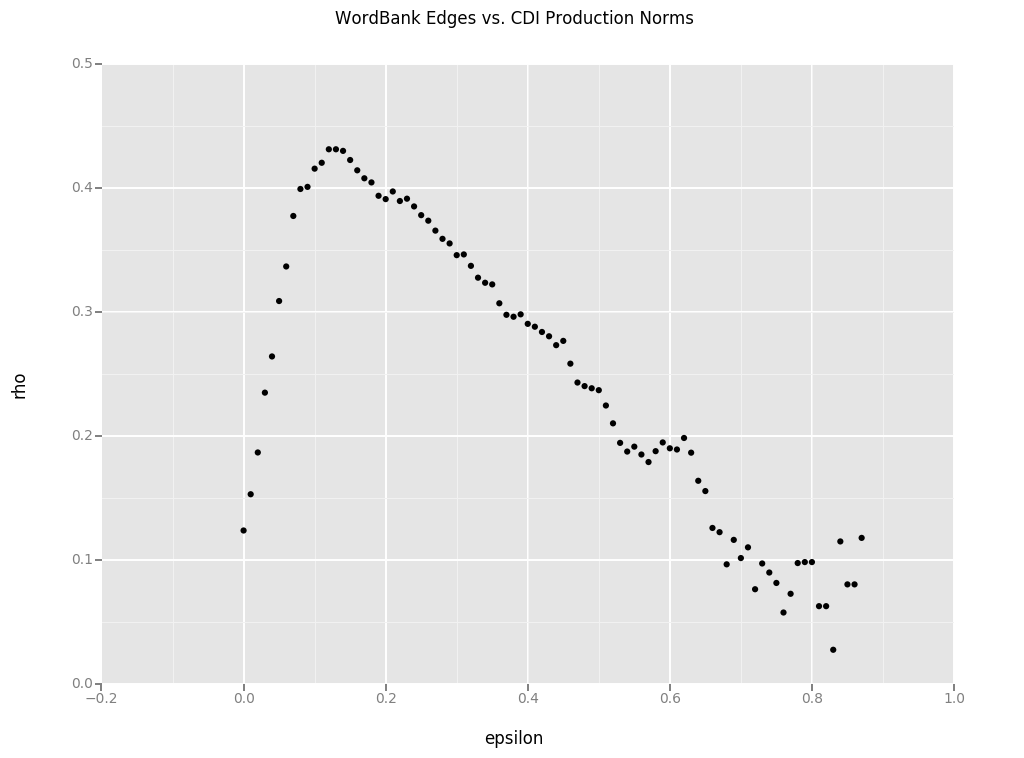

<ggplot: (312570397)>

In [70]:
print("max rho: \n\n{}".format(spearman_wb_df.loc[spearman_wb_df.rho.idxmax()]))

p = ggplot(spearman_wb_df, aes(x='epsilon', y='rho'))+\
    geom_point()+\
    ggtitle('WordBank Edges vs. CDI Production Norms')
    
p.save('graphs/edges_vs_cdi_wordbank.png')
p

In [26]:
%%capture
spearman_df = spearman_dist_range(degree_dists_all, '23')

spearman_df.to_csv('output/edges_vs_cdi_23_seedlings_all.csv', index=False)

max rho: 

epsilon    1.300000e-01
rho        4.974131e-01
p          4.965047e-21
Name: 13, dtype: float64


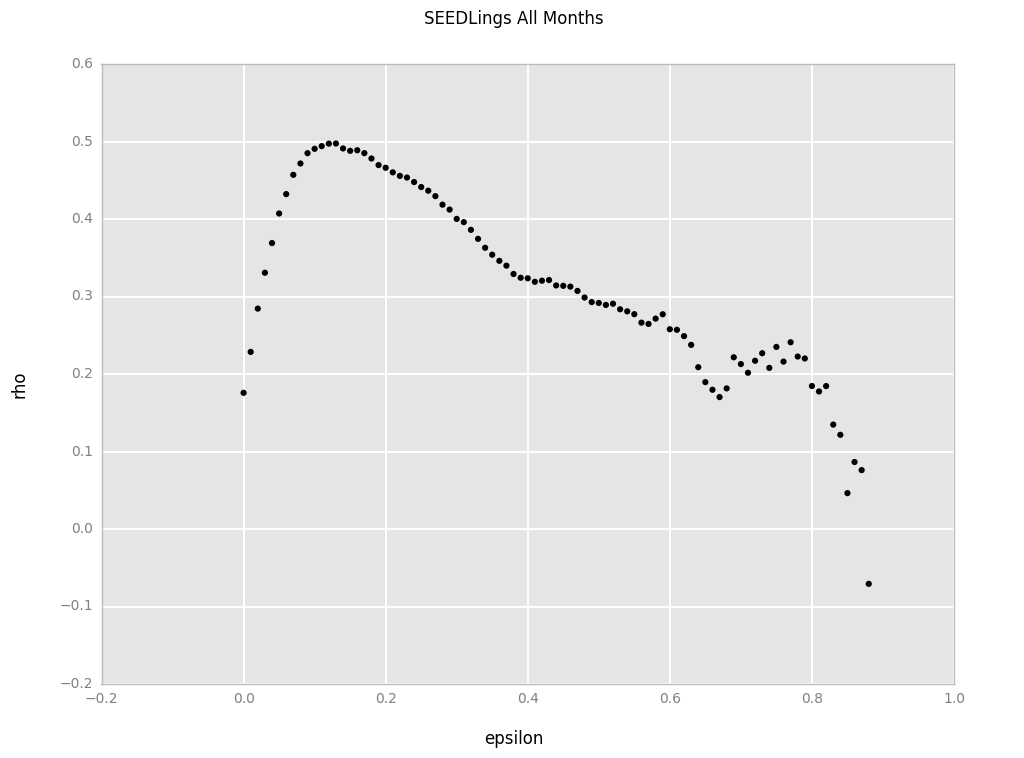

<ggplot: (-9223372036518793258)>

In [27]:
print("max rho: \n\n{}".format(spearman_df.loc[spearman_df.rho.idxmax()]))

p = ggplot(spearman_df, aes(x='epsilon', y='rho'))+\
    theme(axis_title=element_text(color='orange')) +\
    geom_point()+\
    ggtitle('SEEDLings All Months')
    
    
p.save('graphs/edges_vs_cdi_23_seedlings_all.png')
p 

In [28]:
%%capture
spearman_df = spearman_dist_range(degree_dists_6mo, '23')

spearman_df.to_csv('output/edges_vs_cdi_23_seedlings_6mo.csv', index=False)

max rho: 

epsilon    1.700000e-01
rho        5.145486e-01
p          2.497584e-20
Name: 17, dtype: float64


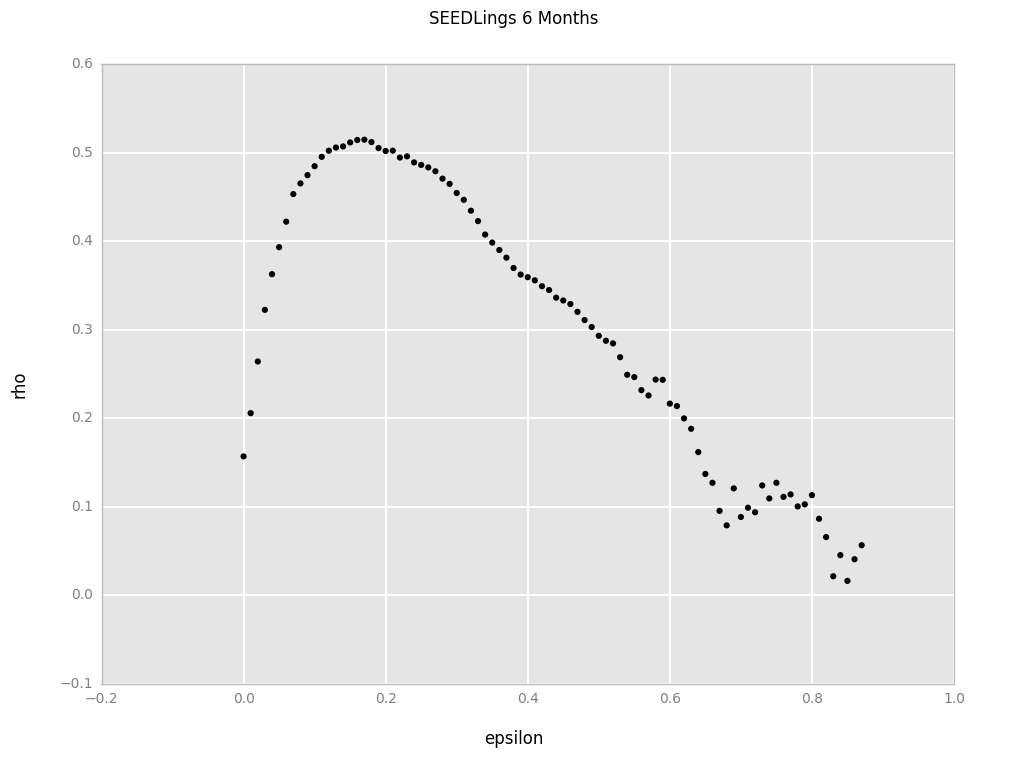

<ggplot: (283252926)>

In [29]:
print("max rho: \n\n{}".format(spearman_df.loc[spearman_df.rho.idxmax()]))

p = ggplot(spearman_df, aes(x='epsilon', y='rho'))+\
    theme(axis_title=element_text(color='orange')) +\
    geom_point()+\
    ggtitle('SEEDLings 6 Months')
    
    
p.save('graphs/edges_vs_cdi_23_seedlings_6mo.png')
p 

In [30]:
%%capture
spearman_df = spearman_dist_range(degree_dists_1617mo, '23')
spearman_df.to_csv('output/edges_vs_cdi_23_seedlings_1617mo.csv', index=False)

max rho: 

epsilon    1.300000e-01
rho        5.206111e-01
p          8.800465e-21
Name: 13, dtype: float64


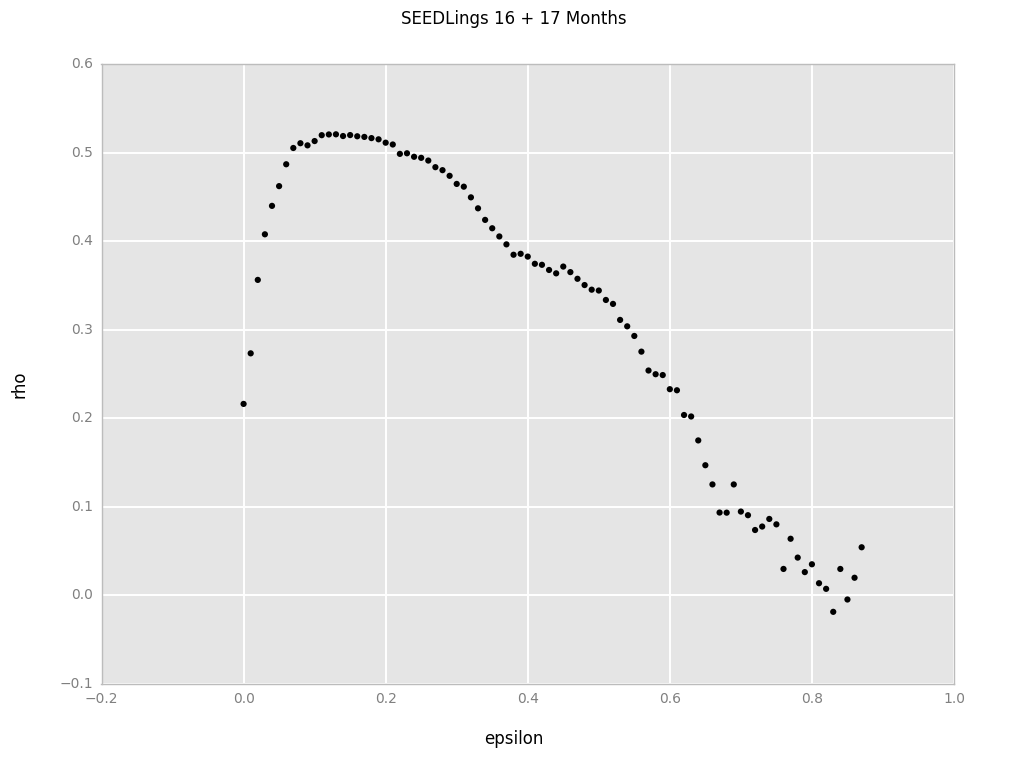

<ggplot: (293913506)>

In [31]:
print("max rho: \n\n{}".format(spearman_df.loc[spearman_df.rho.idxmax()]))

p = ggplot(spearman_df, aes(x='epsilon', y='rho'))+\
    theme(axis_title=element_text(color='orange')) +\
    geom_point()+\
    ggtitle('SEEDLings 16 + 17 Months')
    
    
p.save('graphs/edges_vs_cdi_23_seedlings_1617mo.png')
p 

In [32]:
%%capture
spearman_wb_df = spearman_dist_range(wb_degree_dist, '23')
spearman_wb_df.to_csv('output/edges_vs_cdi_23_wordbank.csv', index=False)

max rho: 

epsilon    1.200000e-01
rho        4.829247e-01
p          3.762569e-21
Name: 12, dtype: float64


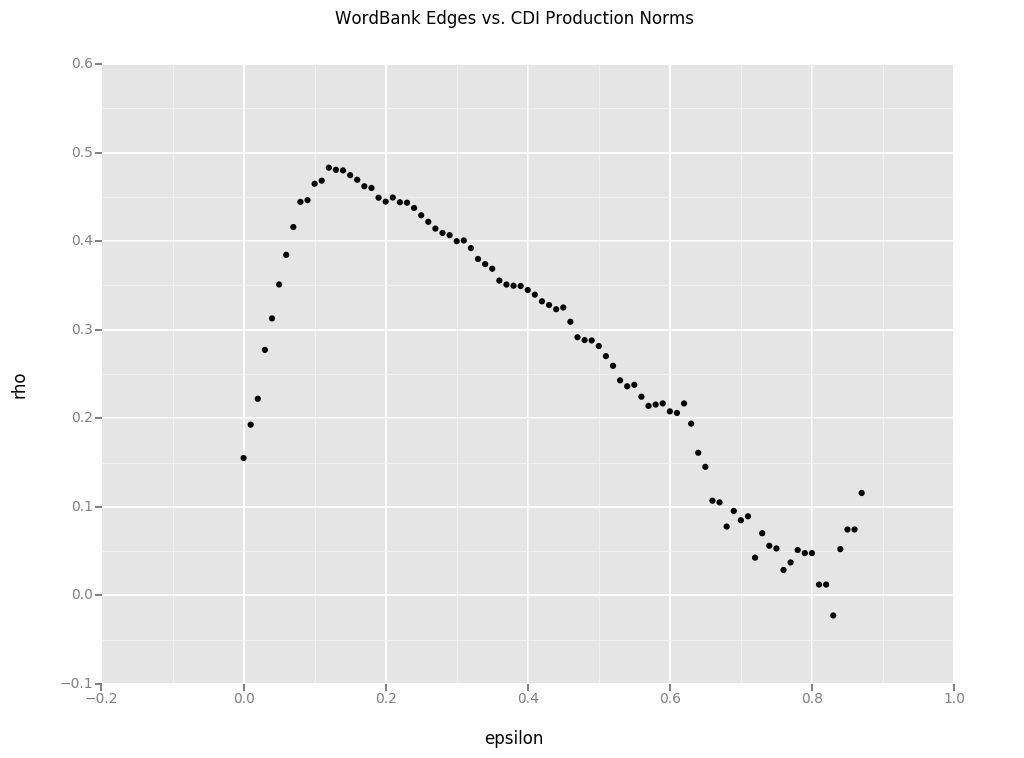

<ggplot: (-9223372036569810821)>

In [33]:
print("max rho: \n\n{}".format(spearman_wb_df.loc[spearman_wb_df.rho.idxmax()]))

p = ggplot(spearman_wb_df, aes(x='epsilon', y='rho'))+\
    geom_point()+\
    ggtitle('WordBank Edges vs. CDI Production Norms')
    
p.save('graphs/edges_vs_cdi_23_wordbank.png')
p

In [35]:
%%capture
spearman_df = spearman_dist_range(degree_dists_all, '30')

spearman_df.to_csv('output/edges_vs_cdi_30_seedlings_all.csv', index=False)

p = ggplot(spearman_df, aes(x='epsilon', y='rho'))+\
    theme(axis_title=element_text(color='orange')) +\
    geom_point()+\
    ggtitle('SEEDLings All Months')
    
    
p.save('graphs/edges_vs_cdi_30_seedlings_all.png')


<ggplot: (386699079)>

max rho: 

epsilon    1.300000e-01
rho        4.670032e-01
p          2.054229e-18
Name: 13, dtype: float64


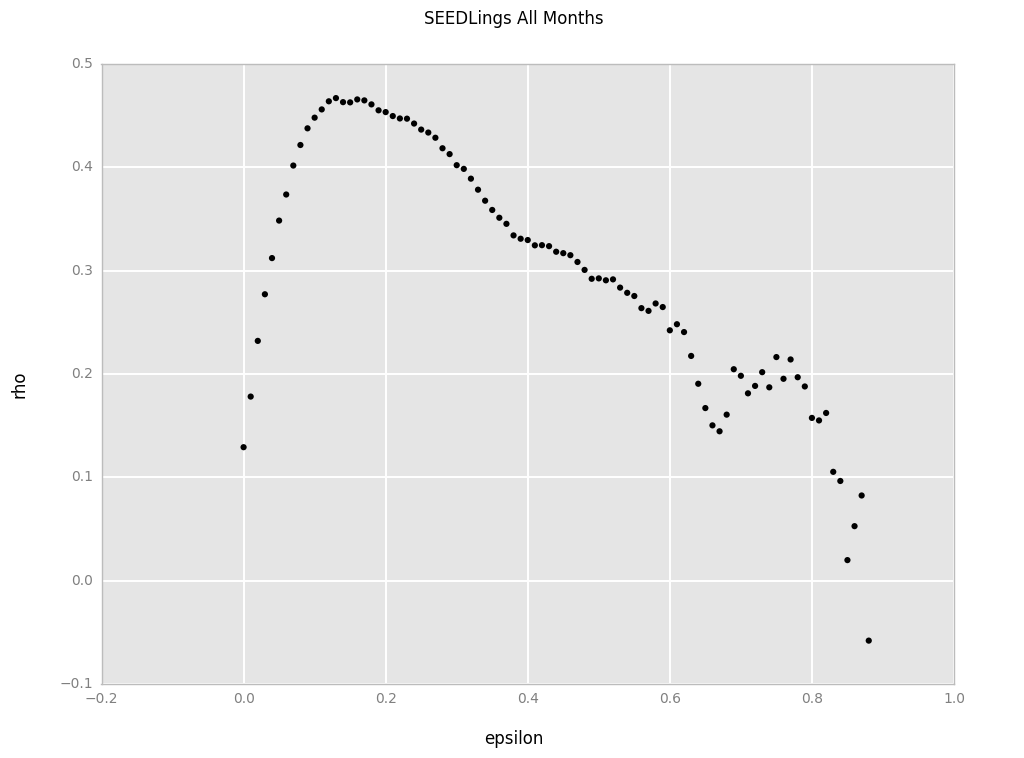

<ggplot: (386699079)>

In [37]:
print("max rho: \n\n{}".format(spearman_df.loc[spearman_df.rho.idxmax()]))
p

In [38]:
%%capture
spearman_df = spearman_dist_range(degree_dists_6mo, '30')

spearman_df.to_csv('output/edges_vs_cdi_30_seedlings_6mo.csv', index=False)

p = ggplot(spearman_df, aes(x='epsilon', y='rho'))+\
    theme(axis_title=element_text(color='orange')) +\
    geom_point()+\
    ggtitle('SEEDLings 6 Months')
    
    
p.save('graphs/edges_vs_cdi_30_seedlings_6mo.png')

max rho: 

epsilon    1.700000e-01
rho        4.977627e-01
p          6.177883e-19
Name: 17, dtype: float64


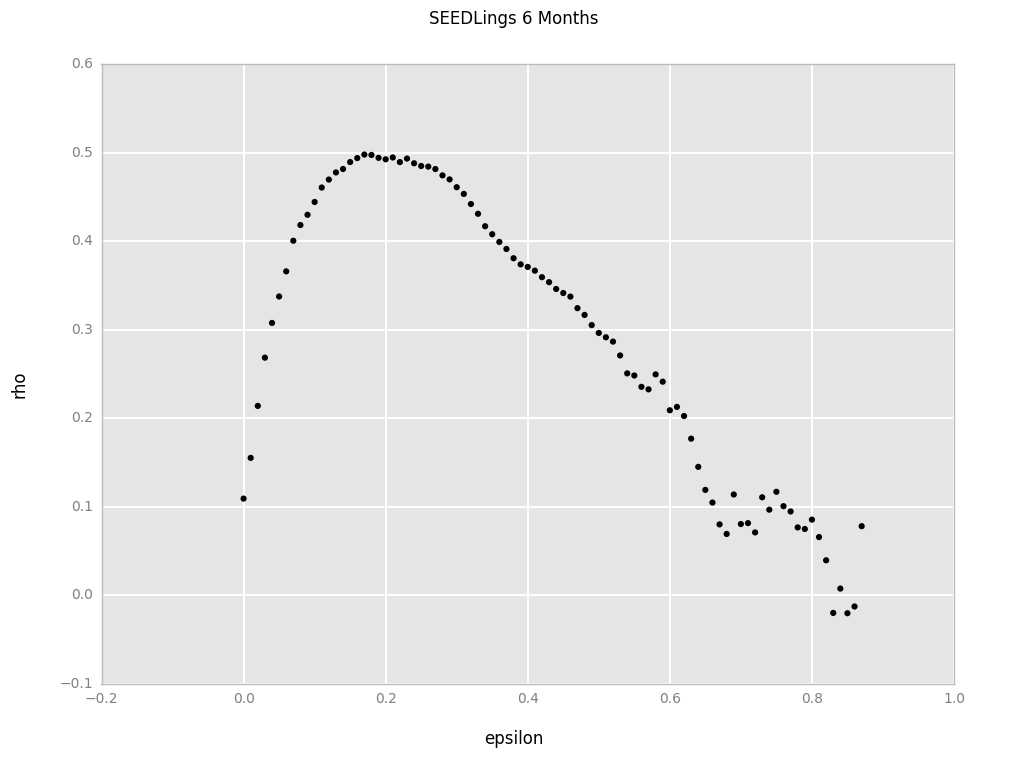

<ggplot: (-9223372036545753333)>

In [40]:
print("max rho: \n\n{}".format(spearman_df.loc[spearman_df.rho.idxmax()]))
p

In [41]:
%%capture
spearman_df = spearman_dist_range(degree_dists_1617mo, '30')

spearman_df.to_csv('output/edges_vs_cdi_30_seedlings_1617mo.csv', index=False)

p = ggplot(spearman_df, aes(x='epsilon', y='rho'))+\
    theme(axis_title=element_text(color='orange')) +\
    geom_point()+\
    ggtitle('SEEDLings 16 + 17 Months')
    
    
p.save('graphs/edges_vs_cdi_30_seedlings_1617mo.png')

max rho: 

epsilon    1.900000e-01
rho        4.968699e-01
p          8.416954e-19
Name: 19, dtype: float64


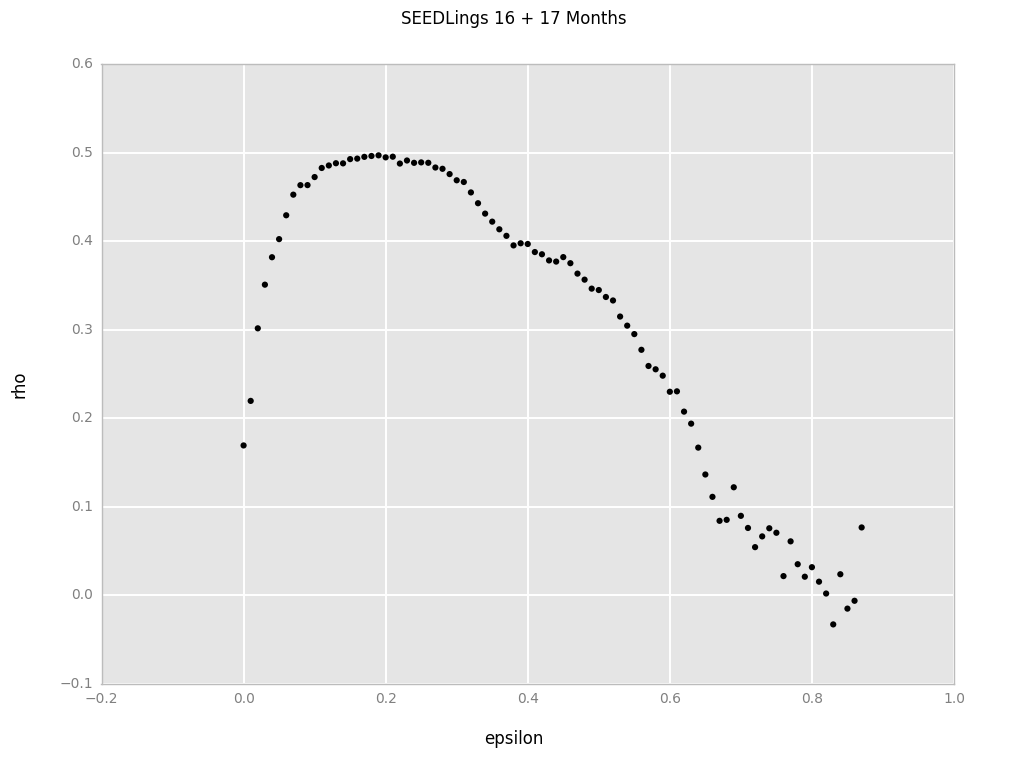

<ggplot: (328303950)>

In [43]:
print("max rho: \n\n{}".format(spearman_df.loc[spearman_df.rho.idxmax()]))
p

In [46]:
%%capture
spearman_wb_df = spearman_dist_range(wb_degree_dist, '30')
spearman_wb_df.to_csv('output/edges_vs_cdi_30_wordbank.csv', index=False)

max rho: 

epsilon    1.200000e-01
rho        4.734524e-01
p          2.759454e-20
Name: 12, dtype: float64


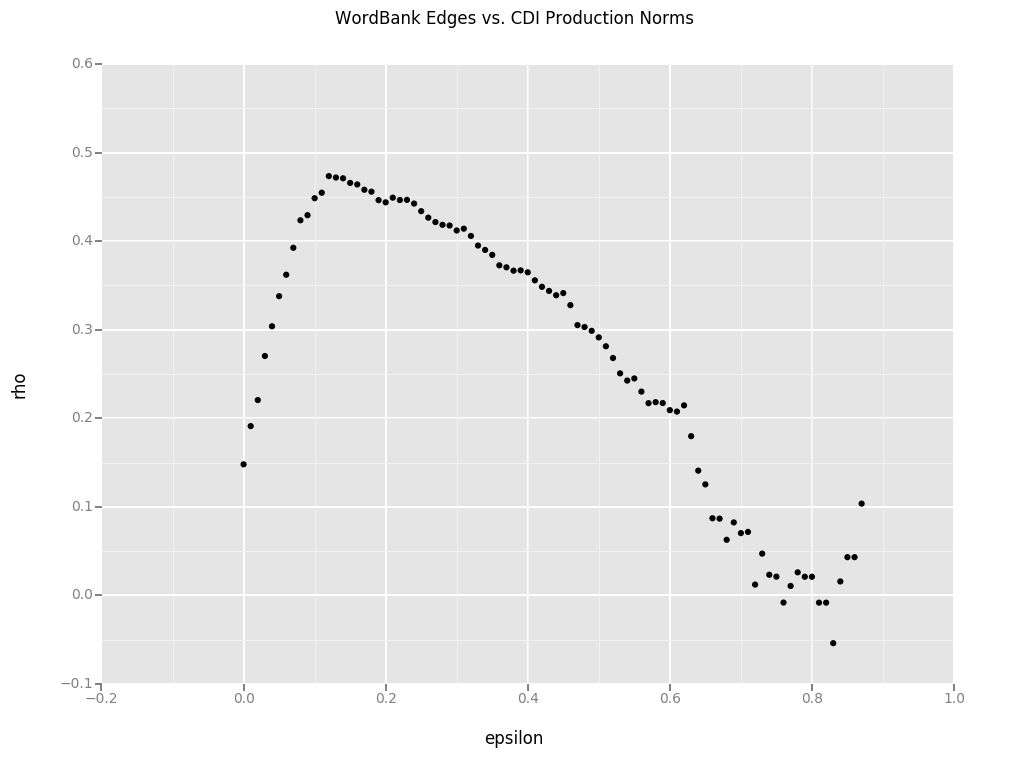

<ggplot: (-9223372036504778268)>

In [47]:
print("max rho: \n\n{}".format(spearman_wb_df.loc[spearman_wb_df.rho.idxmax()]))

p = ggplot(spearman_wb_df, aes(x='epsilon', y='rho'))+\
    geom_point()+\
    ggtitle('WordBank Edges vs. CDI Production Norms')
    
p.save('graphs/edges_vs_cdi_30_wordbank.png')
p